In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import shap

import events_package.utils as utils
from events_package.Experiment import Experiment
from events_package.config import FIVE_LAYERS
from events_package.input_getters import get_Y_1, get_X_3, get_X_4, get_X_5

In [2]:
Experiment.__version__

'5.0'

# 1. Importing Single Particle Data

## 1.1 Electrons

In [3]:
# importing data
electrons_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Electron\Parquet\1m_electron_pq_3"
)

electrons = Experiment(electrons_df, config=FIVE_LAYERS)
electrons.length

444840

In [4]:
electrons.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434998
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434998


## 1.2 Photons

In [5]:
photons_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Photon\Parquet\1m_photon_pq"
)

photons = Experiment(photons_df, config=FIVE_LAYERS)
photons.length

444142

In [6]:
photons.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434870
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434870


## 1.3 Neutral Pions

In [7]:
pi0_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\PiZero\Parquet\pq_pi0_2"
)

pi0 = Experiment(pi0_df, config=FIVE_LAYERS)
pi0.length

412856

In [8]:
pi0.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 391483
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 391483


## 1.4 Charged Pions

In [9]:
pi_char_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\PiPlusMinus\Parquet\pq_piplusminus_2"
)

pi_char = Experiment(pi_char_df, config=FIVE_LAYERS)
pi_char.length

357554

In [10]:
pi_char.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 330809
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 330809


## 1.5 Combined Particle Data

In [11]:
# add types to allow for identification later
electrons.add_physics_object_type(typ="electron")
photons.add_physics_object_type(typ="photon")
pi0.add_physics_object_type(typ="pi0")
pi_char.add_physics_object_type(typ="pi_char")

In [12]:
# combine the datasets
experiment = electrons + photons + pi0 + pi_char

# all previous datasets have already been denoisified, duplicates were removed, no need to do it now
# in fact, doing it would delete some good events
experiment.shuffle_dataset(repeats=11)
print(experiment.length)

1592160


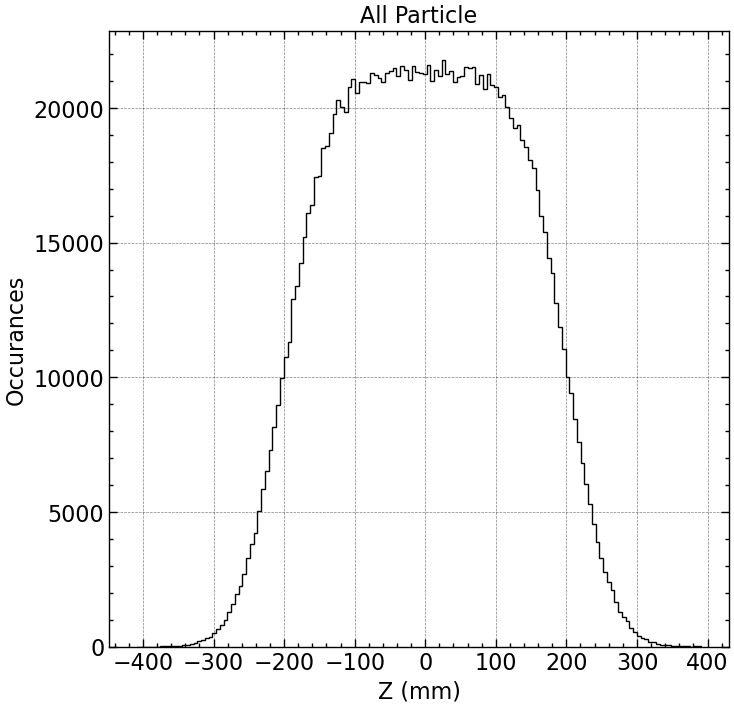

In [13]:
with plt.style.context(["science", "notebook", "grid"]):
    plt.figure(figsize=(8, 8))
    plt.hist(
        experiment.z,
        bins=150,
        histtype="step",
        label="Electrons",
        color="k",
        density=False,
    )
    plt.xlabel("Z (mm)")
    plt.ylabel("Occurances")
    plt.title("All Particle")
    plt.show()

# 2. Effect of Cut in Z

In [14]:
# hyperparameters used
params = {
    "objective": "reg:squarederror",
    "max_depth": 6,
    "learning_rate": 0.18,
    "colsample_bytree": 0.8,
    "eval_metric": "rmse",
    "n_estimators": 600,
}

## 2.1 Trained Without Cut, Tested Without Cut

In [15]:
# split data into training and testing, next train XGBoost model
experiment.train_test_split(get_X=get_X_5, get_Y=get_Y_1, test_size=0.2)
print(experiment.X_train.shape)
print(experiment.X_test.shape)

experiment.train_xgboost_model(params)

(1273728, 22)
(318433, 22)
INFO: Trained XGBoost model; mean squared error: 3655.5840579032492


3655.5840579032492

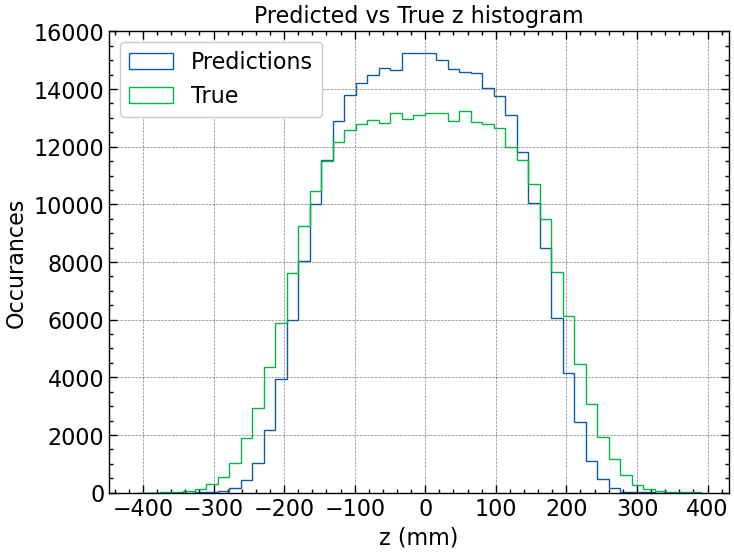

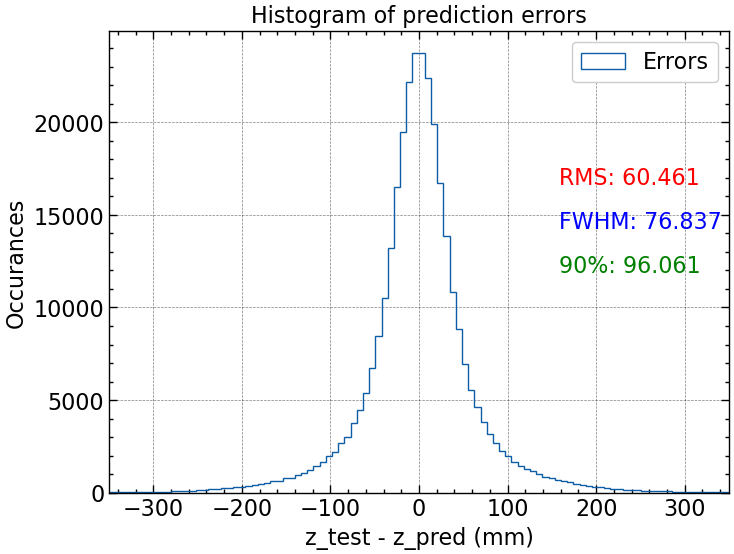

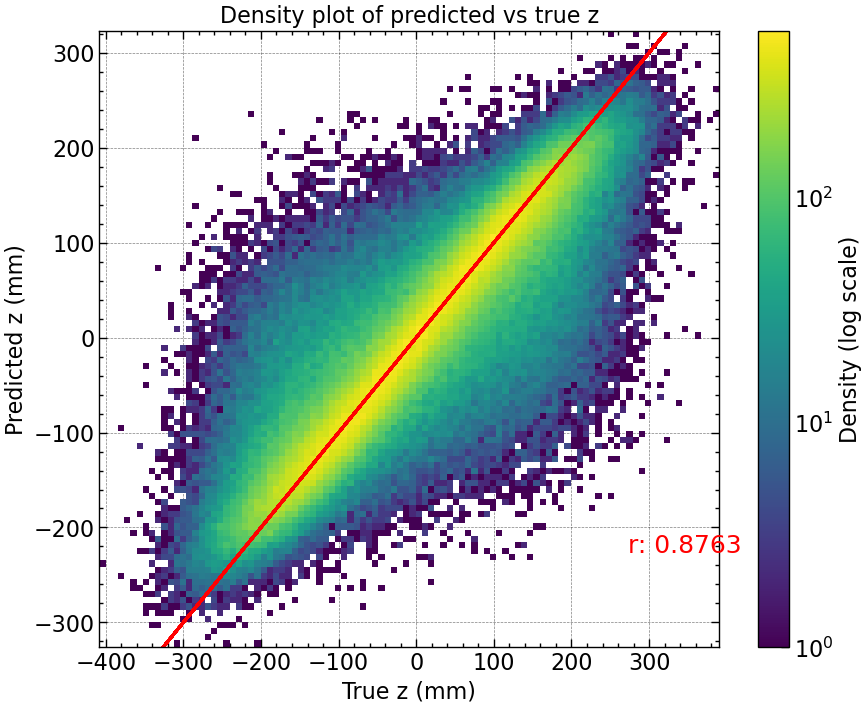

In [16]:
Y_test = experiment.y_test
Y_pred = experiment.y_pred
utils.plot_predictions(Y_test, Y_pred)

utils.plot_errors(Y_test, Y_pred, xmax=350, xcut=350, binnum=100)

utils.plot_corelation(Y_test, Y_pred, density=True, log_density=True, plot_line=True)

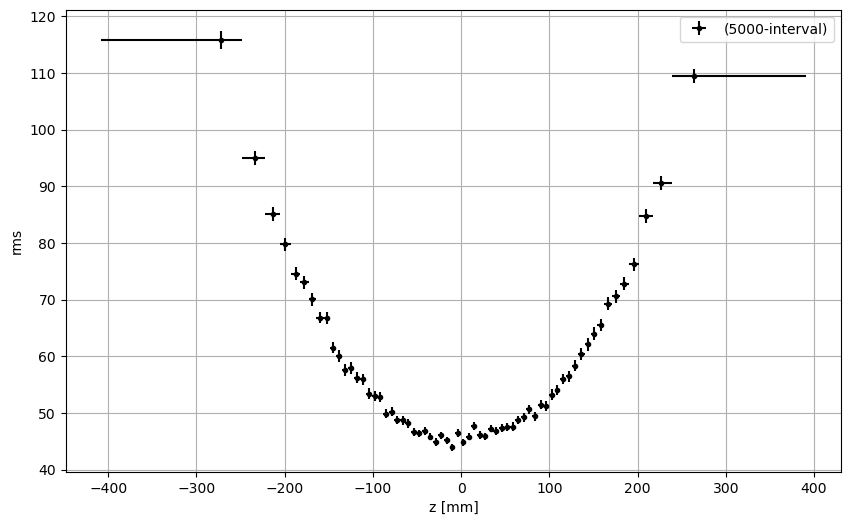

In [17]:
utils.plot_avg(
    x_values=experiment.testing_dataset["z"].values,
    y_values=(experiment.y_test - experiment.y_pred),
    interval=5000,
    xlabel="z [mm]",
    rms=True,
    return_values=False,
    ylabel="rms",
    return_x_u=True,
    plot=True,
)

## 2.2 Trained Without Cut, Tested With Cut

In [18]:
experiment.z_cut(z_threshold=125, data="testing")
print(experiment.X_test.shape)

experiment.train_xgboost_model(params)

(197286, 22)
INFO: Trained XGBoost model; mean squared error: 2431.6236665108972


2431.6236665108972

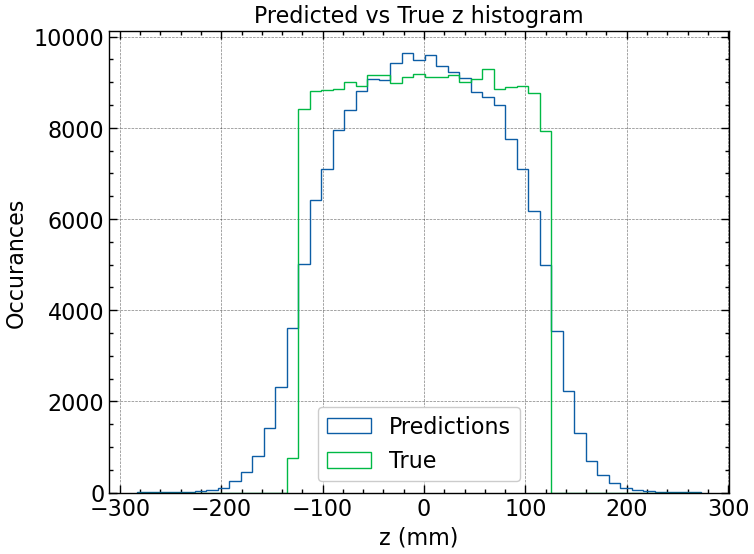

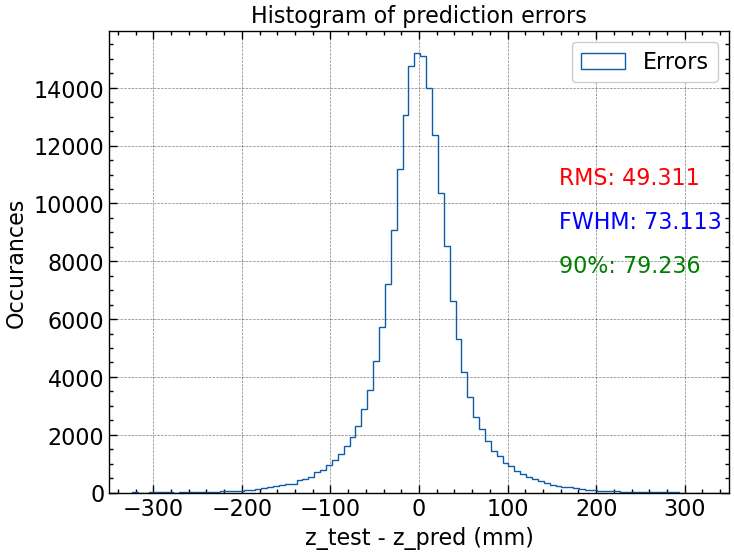

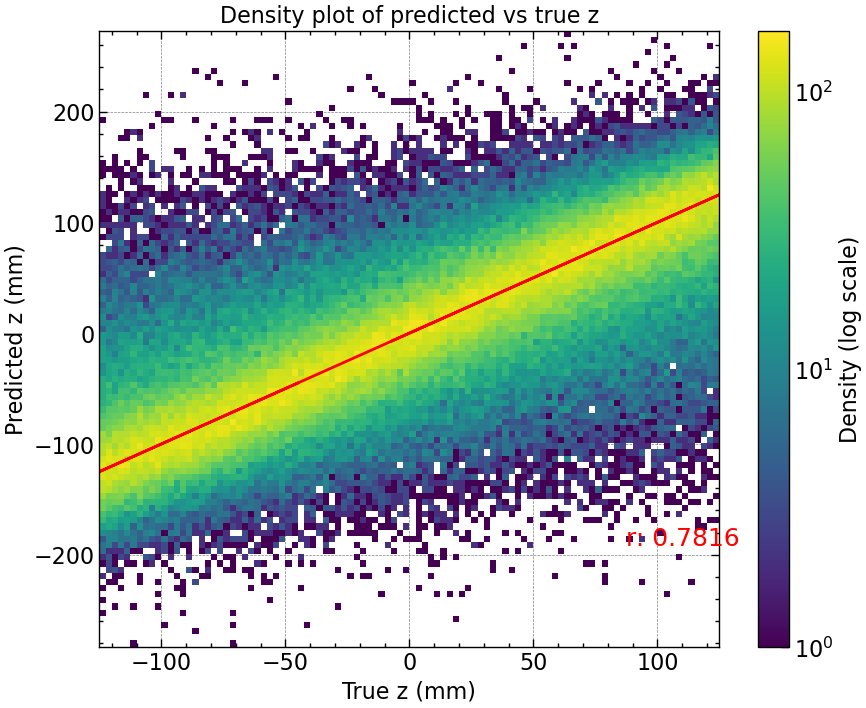

In [19]:
Y_test = experiment.y_test
Y_pred = experiment.y_pred
utils.plot_predictions(Y_test, Y_pred)

utils.plot_errors(Y_test, Y_pred, xmax=350, xcut=350, binnum=100)

utils.plot_corelation(Y_test, Y_pred, density=True, log_density=True, plot_line=True)

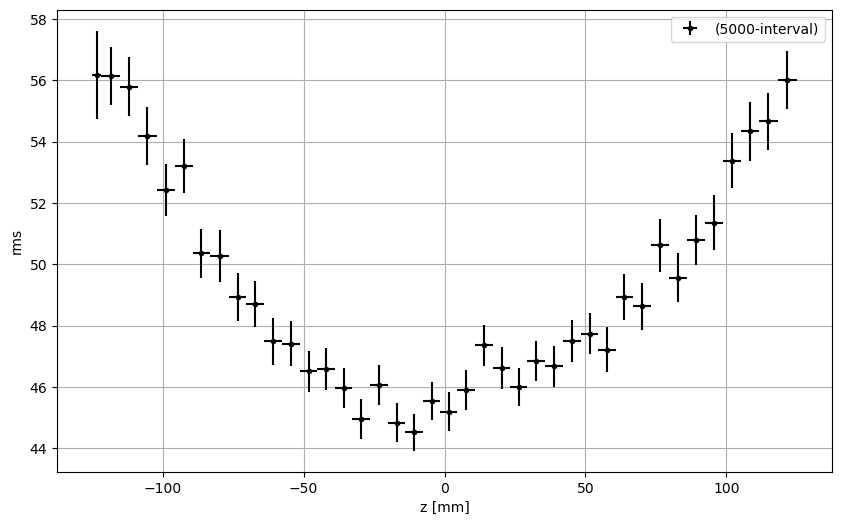

In [20]:
utils.plot_avg(
    x_values=experiment.testing_dataset["z"].values,
    y_values=(experiment.y_test - experiment.y_pred),
    interval=5000,
    xlabel="z [mm]",
    rms=True,
    return_values=False,
    ylabel="rms",
    return_x_u=True,
    plot=True,
)

## 2.3 Trained Without Cut, Tested With Cut

In [21]:
# reset
electrons = Experiment(electrons_df, config=FIVE_LAYERS)
electrons.standard_procedure()

photons = Experiment(photons_df, config=FIVE_LAYERS)
photons.standard_procedure()

pi0 = Experiment(pi0_df, config=FIVE_LAYERS)
pi0.standard_procedure()

pi_char = Experiment(pi_char_df, config=FIVE_LAYERS)
pi_char.standard_procedure()

# add types to allow for identification later
electrons.add_physics_object_type(typ="electron")
photons.add_physics_object_type(typ="photon")
pi0.add_physics_object_type(typ="pi0")
pi_char.add_physics_object_type(typ="pi_char")

experiment = electrons + photons + pi0 + pi_char

experiment.shuffle_dataset(repeats=11)

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434998
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434998
INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434870
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434870
INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 391483
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 391483
INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 330809
INFO: Removed events with 0 

In [22]:
experiment.train_test_split(get_X=get_X_5, get_Y=get_Y_1, test_size=0.2)

experiment.z_cut(z_threshold=125, data="training")
print(experiment.X_train.shape)

experiment.train_xgboost_model(params)

(790421, 22)
INFO: Trained XGBoost model; mean squared error: 5320.095703165236


5320.095703165236

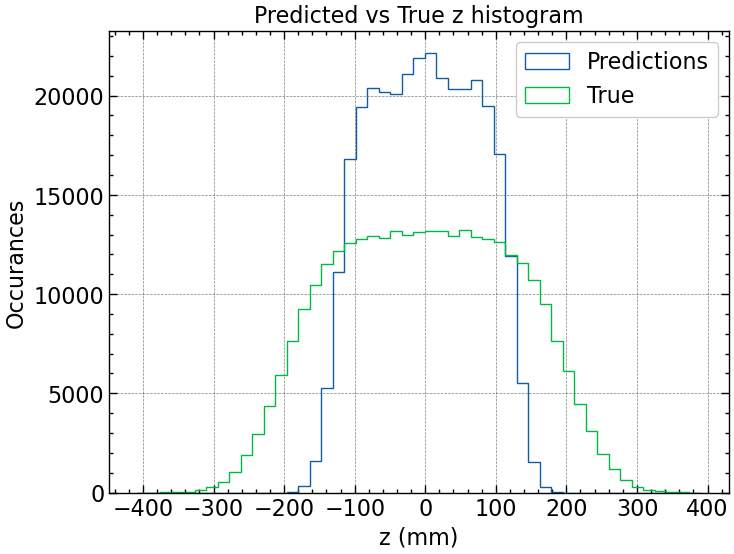

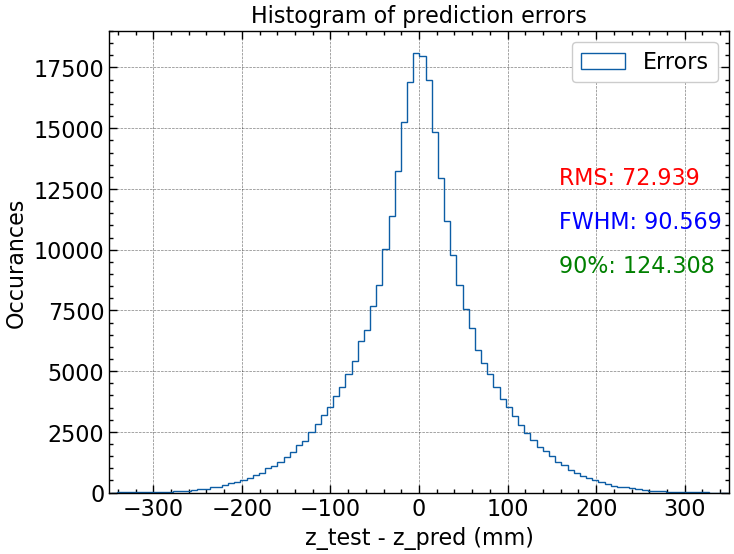

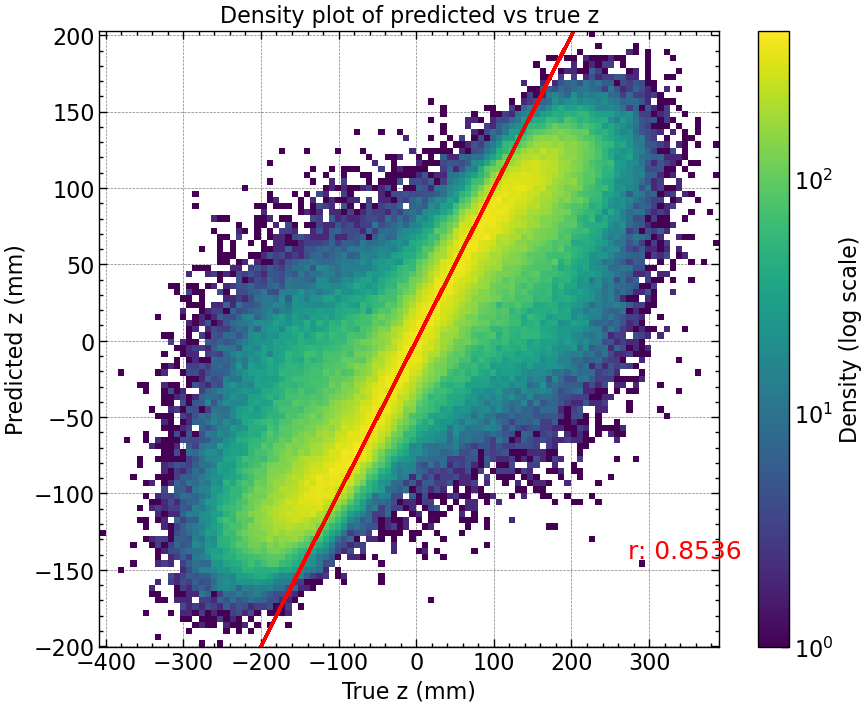

In [23]:
Y_test = experiment.y_test
Y_pred = experiment.y_pred
utils.plot_predictions(Y_test, Y_pred)

utils.plot_errors(Y_test, Y_pred, xmax=350, xcut=350, binnum=100)

utils.plot_corelation(Y_test, Y_pred, density=True, log_density=True, plot_line=True)

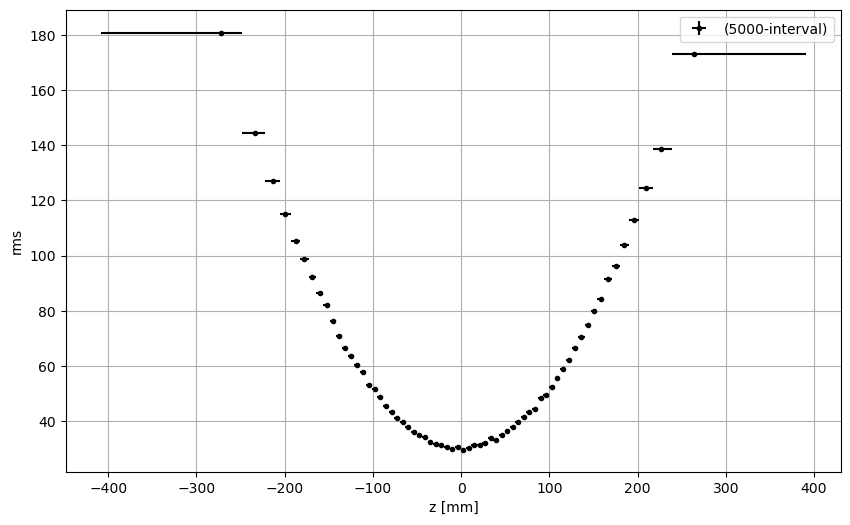

In [24]:
utils.plot_avg(
    x_values=experiment.testing_dataset["z"].values,
    y_values=(experiment.y_test - experiment.y_pred),
    interval=5000,
    xlabel="z [mm]",
    rms=True,
    return_values=False,
    ylabel="rms",
    return_x_u=True,
    plot=True,
)

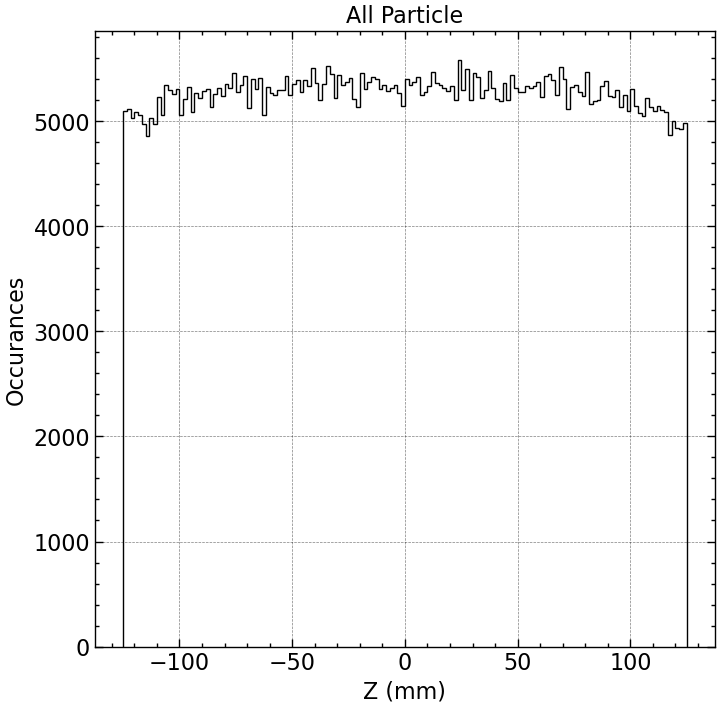

In [25]:
with plt.style.context(["science", "notebook", "grid"]):
    plt.figure(figsize=(8, 8))
    plt.hist(
        experiment.training_dataset.z,
        bins=150,
        histtype="step",
        label="Electrons",
        color="k",
        density=False,
    )
    plt.xlabel("Z (mm)")
    plt.ylabel("Occurances")
    plt.title("All Particle")
    plt.show()

## 2.4 Trained With Cut, Tested With Cut

In [26]:
experiment.z_cut(z_threshold=125, data="testing")
print(experiment.X_test.shape)

experiment.train_xgboost_model(params)

(197286, 22)
INFO: Trained XGBoost model; mean squared error: 1792.2622225063817


1792.2622225063817

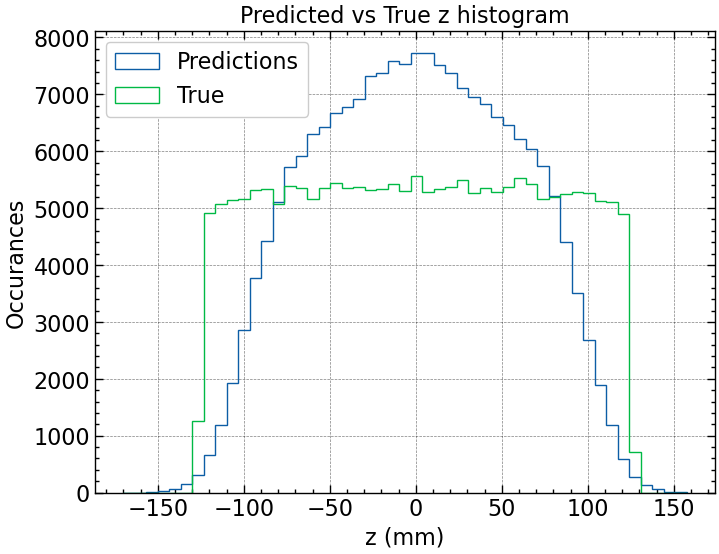

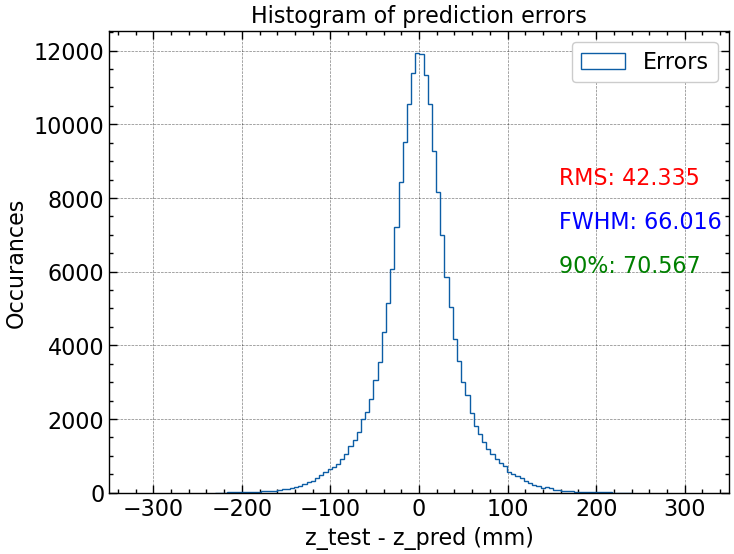

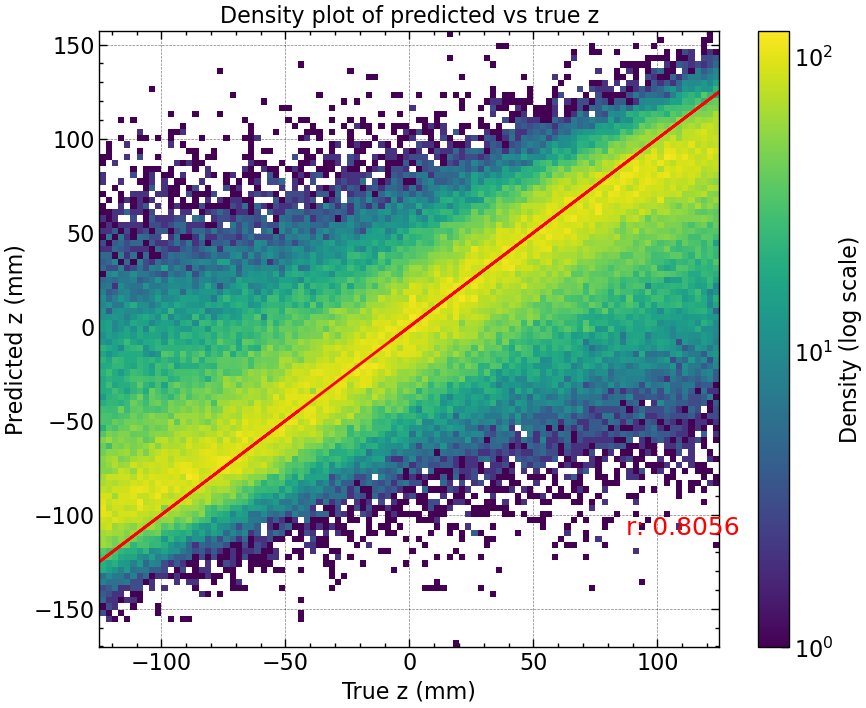

In [27]:
Y_test = experiment.y_test
Y_pred = experiment.y_pred
utils.plot_predictions(Y_test, Y_pred)

utils.plot_errors(Y_test, Y_pred, xmax=350, xcut=350, binnum=100)

utils.plot_corelation(Y_test, Y_pred, density=True, log_density=True, plot_line=True)

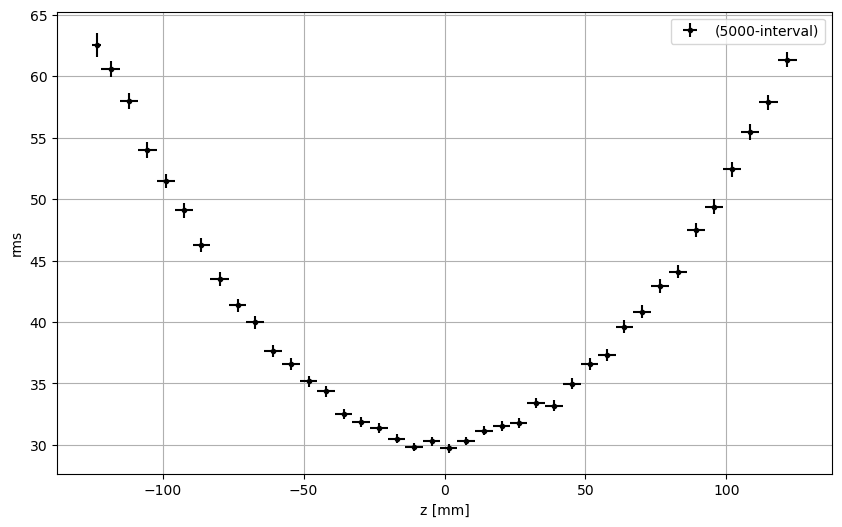

In [28]:
utils.plot_avg(
    x_values=experiment.testing_dataset["z"].values,
    y_values=(experiment.y_test - experiment.y_pred),
    interval=5000,
    xlabel="z [mm]",
    rms=True,
    return_values=False,
    ylabel="rms",
    return_x_u=True,
    plot=True,
)

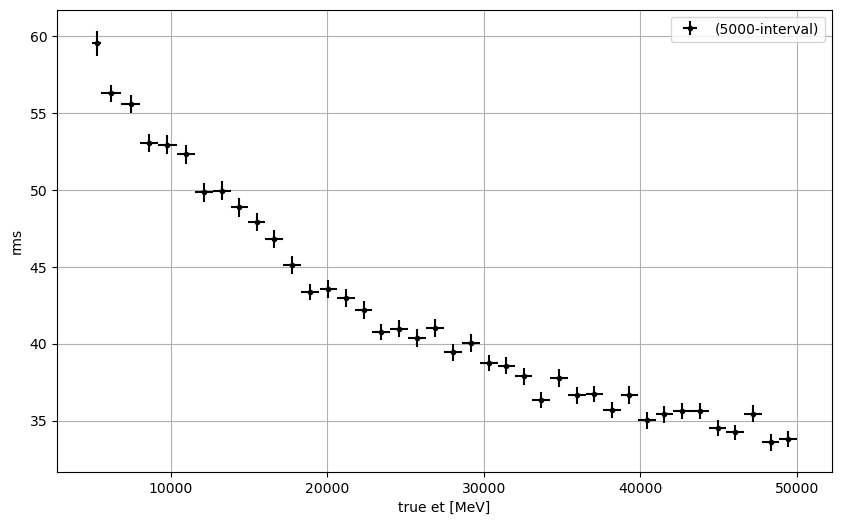

In [29]:
utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values,
    y_values=(experiment.y_test - experiment.y_pred),
    interval=5000,
    xlabel="true et [MeV]",
    rms=True,
    return_values=False,
    ylabel="rms",
    return_x_u=True,
    plot=True,
)

In [30]:
mask_e = experiment.testing_dataset.physics_object_type == "electron"
mask_p = experiment.testing_dataset.physics_object_type == "photon"
mask_pi0 = experiment.testing_dataset.physics_object_type == "pi0"
mask_pi_char = experiment.testing_dataset.physics_object_type == "pi_char"

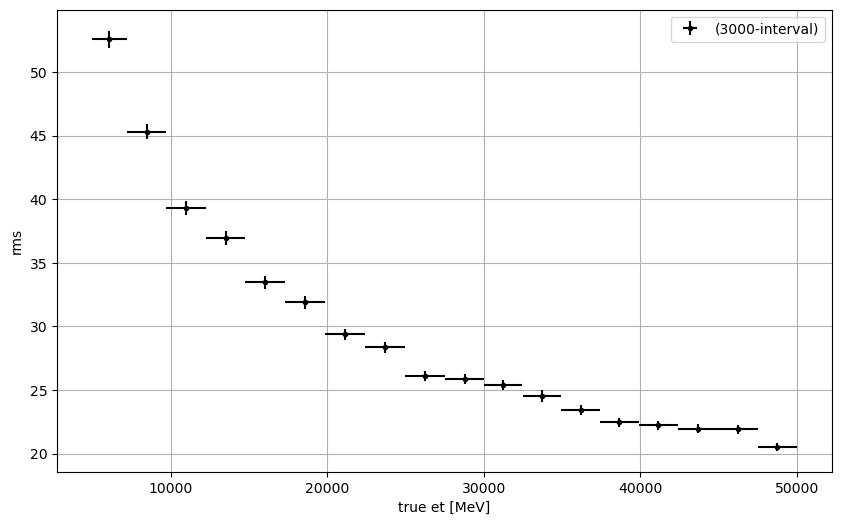

In [31]:
utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_e],
    y_values=(experiment.y_test - experiment.y_pred)[mask_e],
    interval=3000,
    xlabel="true et [MeV]",
    rms=True,
    return_values=False,
    ylabel="rms",
    return_x_u=True,
    plot=True,
)